In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/name_mapping_validation_data.csv
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/survival_evaluation.csv
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_084/BraTS20_Validation_084_flair.nii
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_084/BraTS20_Validation_084_t2.nii
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_084/BraTS20_Validation_084_t1ce.nii
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_084/BraTS20_Validation_084_t1.nii
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_Br

In [3]:
# Python cell
import os, sys, glob, random, math, time, shutil
from pathlib import Path
import numpy as np
import nibabel as nib
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [4]:

DATA_DIR = "/kaggle/input/brats20-dataset-training-validation" 
AUTO_CREATE_SYNTHETIC_IF_EMPTY = True 

candidate_paths = []

if DATA_DIR:
    candidate_paths.insert(0, DATA_DIR)

found = None
for p in candidate_paths:
    if os.path.exists(p) and len(list(Path(p).rglob("*.nii*")))>0:
        found = p
        break

if found:
    DATA_DIR = found
    print("Using dataset at:", DATA_DIR)
else:
    print("No existing BraTS-like dataset found in common locations.")
    if DATA_DIR:
        print(f"Your configured DATA_DIR = {DATA_DIR} was not found or contains no .nii files.")
    if AUTO_CREATE_SYNTHETIC_IF_EMPTY:
        DATA_DIR = "/tmp/brats_synthetic"
        print("Will create a small synthetic dataset at", DATA_DIR)
    else:
        raise FileNotFoundError("BraTS dataset not found. Set DATA_DIR or enable synthetic fallback.")


Using dataset at: /kaggle/input/brats20-dataset-training-validation


In [5]:
# Python cell
def create_synthetic_brats(root, n_cases=4, vol_shape=(128,128,64)):
    """
    Create a tiny synthetic dataset: each case folder contains flair, t1, t1ce, t2 and seg (nii.gz)
    Seg labels use {0,1,4} to mimic BraTS.
    """
    root = Path(root)
    if root.exists():
        shutil.rmtree(root)
    root.mkdir(parents=True, exist_ok=True)
    rng = np.random.RandomState(42)
    for i in range(n_cases):
        case = root / f'case_{i:03d}'
        case.mkdir()
        H,W,D = vol_shape
        # base anatomy noise
        base = rng.normal(loc=0.0, scale=1.0, size=(H,W,D)).astype(np.float32)
        # random sphere tumor
        cx = rng.randint(H//4, 3*H//4)
        cy = rng.randint(W//4, 3*W//4)
        cz = rng.randint(D//4, 3*D//4)
        rr,cc,zz = np.ogrid[:H,:W,:D]
        mask = ((rr-cx)**2 + (cc-cy)**2 + (zz-cz)**2) < (min(H,W)//8)**2
        seg = np.zeros((H,W,D), dtype=np.uint8)
        seg[mask] = 1  # non-enhancing component
        # add enhancing core (label 4) — smaller sphere inside
        mask2 = ((rr-cx)**2 + (cc-cy)**2 + (zz-cz)**2) < (min(H,W)//12)**2
        seg[mask2] = 4
        # modalities with different contrasts
        flair = base + seg.astype(np.float32)*3.0 + rng.normal(0,0.2, size=(H,W,D))
        t1   = base + seg.astype(np.float32)*1.5 + rng.normal(0,0.2, size=(H,W,D))
        t1ce = base + seg.astype(np.float32)*4.0 + rng.normal(0,0.2, size=(H,W,D))
        t2   = base + seg.astype(np.float32)*2.0 + rng.normal(0,0.2, size=(H,W,D))
        # save with nibabel
        def save(arr, path):
            nii = nib.Nifti1Image(arr.astype(np.float32), affine=np.eye(4))
            nib.save(nii, str(path))
        save(flair, case / f'case_{i:03d}_flair.nii.gz')
        save(t1,   case / f'case_{i:03d}_t1.nii.gz')
        save(t1ce, case / f'case_{i:03d}_t1ce.nii.gz')
        save(t2,   case / f'case_{i:03d}_t2.nii.gz')
        save(seg,  case / f'case_{i:03d}_seg.nii.gz')
    print(f"Created {n_cases} synthetic cases at {root}")

# create synthetic if needed
if DATA_DIR == "/tmp/brats_synthetic":
    create_synthetic_brats(DATA_DIR, n_cases=4, vol_shape=(128,128,64))


In [6]:
# Python cell
class Brats2DSliceDataset(Dataset):
    """
    Robust slice-based dataset with recursive filesystem discovery.
    If no tumor slices are desired, set min_tumor_slice=False.
    """
    def __init__(self, root_dir, mode='train', target_size=256, transforms=None, min_tumor_slice=True):
        super().__init__()
        self.root_dir = Path(root_dir)
        self.mode = mode
        self.transforms = transforms
        self.target_size = int(target_size)
        self.min_tumor_slice = bool(min_tumor_slice)
        # find cases
        self.cases = self._discover_cases()
        # build slice index
        self.index = []
        self._build_index()
        print(f"Dataset ready. cases: {len(self.cases)}, total_slices_indexed: {len(self.index)}")

    def _discover_cases(self):
        # look for seg files and pair modalities in the same folder
        seg_files = list(self.root_dir.rglob("*seg*.nii*"))
        if not seg_files:
            # try other heuristics if none found
            seg_files = [p for p in self.root_dir.rglob("*.nii*") if 'seg' in p.name.lower() or 'mask' in p.name.lower()]
        cases = []
        for seg in seg_files:
            folder = seg.parent
            files = {f.name.lower(): str(f) for f in folder.iterdir() if f.is_file()}
            def find_mod(subs):
                for name, path in files.items():
                    for s in subs:
                        if s in name:
                            return path
                return None
            flair = find_mod(['flair'])
            t1   = find_mod(['t1ce','t1_gd','t1ce.nii','t1ce'])
            if t1 is None:
                t1 = find_mod(['t1.nii','t1'])
            t2   = find_mod(['t2'])
            segp = str(seg)
            if flair and t1 and t1 and t2 and segp:
                cases.append({'folder': str(folder), 'flair': flair, 't1': t1, 't1ce': t1, 't2': t2, 'seg': segp})
            else:
                # try sibling files with similar prefix in parent folder
                parent = folder.parent
                siblings = list(parent.glob("*"))
                files2 = {f.name.lower(): str(f) for f in siblings if f.is_file()}
                flair = flair or (files2.get(next((k for k in files2 if 'flair' in k), None)))
                t1 = t1 or (files2.get(next((k for k in files2 if 't1ce' in k or 't1_gd' in k), None)))
                t2 = t2 or (files2.get(next((k for k in files2 if 't2' in k), None)))
                if flair and t1 and t2:
                    cases.append({'folder': str(parent), 'flair': flair, 't1': t1, 't1ce': t1, 't2': t2, 'seg': segp})
        if not cases:
            print("No case pairs found automatically. Make sure your dataset has files named like *_flair.nii.gz and *_seg.nii.gz.")
        return cases

    def _build_index(self):
        print("Building slice index...")
        for case in tqdm(self.cases):
            seg_arr = nib.load(case['seg']).get_fdata().astype(np.int16)
            nz = seg_arr.shape[2]
            for z in range(nz):
                if self.min_tumor_slice:
                    if seg_arr[:,:,z].sum() == 0:
                        continue
                self.index.append((case, z))

    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx):
        case, z = self.index[idx]
        flair = nib.load(case['flair']).get_fdata()[:,:,z].astype(np.float32)
        t1   = nib.load(case['t1']).get_fdata()[:,:,z].astype(np.float32)
        t1ce = nib.load(case['t1ce']).get_fdata()[:,:,z].astype(np.float32)
        t2   = nib.load(case['t2']).get_fdata()[:,:,z].astype(np.float32)
        seg  = nib.load(case['seg']).get_fdata()[:,:,z].astype(np.int16)

        # normalize channels (z-score)
        def zscore(x):
            x = x.astype(np.float32)
            m = x.mean(); s = x.std()
            return (x - m) / (s + 1e-8)

        flair = zscore(flair)
        t1   = zscore(t1)
        t1ce = zscore(t1ce)
        t2   = zscore(t2)

        # resize (images: bilinear; seg: nearest)
        H = W = self.target_size
        def rimg(x):
            return cv2.resize(x.astype(np.float32), (W,H), interpolation=cv2.INTER_LINEAR)
        def rseg(x):
            return cv2.resize(x.astype(np.float32), (W,H), interpolation=cv2.INTER_NEAREST)

        flair = rimg(flair)
        t1   = rimg(t1)
        t1ce = rimg(t1ce)
        t2   = rimg(t2)
        seg   = rseg(seg)

        # convert seg -> three channels (WT, TC, ET)
        seg = np.rint(seg).astype(np.int16)
        wt = (seg > 0).astype(np.uint8)
        et_label = 4 if (seg==4).any() else (3 if (seg==3).any() else 4)
        tc = np.logical_or(seg==1, seg==et_label).astype(np.uint8)
        et = (seg==et_label).astype(np.uint8)
        y = np.stack([wt, tc, et], axis=0).astype(np.float32)  # (3,H,W)

        x = np.stack([flair, t1, t1ce, t2], axis=0).astype(np.float32)  # (4,H,W)

        # optional transforms (albumentations expects HWC)
        if self.transforms:
            import albumentations as A
            img_hwc = np.transpose(x, (1,2,0))
            mask_hwc = np.transpose(y, (1,2,0))
            augmented = self.transforms(image=img_hwc, mask=mask_hwc)
            img_hwc = augmented['image']
            mask_hwc = augmented['mask']
            x = np.transpose(img_hwc, (2,0,1)).astype(np.float32)
            y = np.transpose(mask_hwc, (2,0,1)).astype(np.float32)

        return torch.from_numpy(x).float(), torch.from_numpy(y).float()


In [7]:
# Python cell
import albumentations as A
train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.5, border_mode=cv2.BORDER_REFLECT),
    A.RandomBrightnessContrast(p=0.3),
], additional_targets={'mask': 'mask'})

target_size = 256
ds = Brats2DSliceDataset(DATA_DIR, mode='train', target_size=target_size, transforms=train_transforms, min_tumor_slice=True)

# If empty, allow non-min_tumor and reindex or create synthetic if allowed
if len(ds) == 0:
    print("No tumor slices found with min_tumor_slice=True. Rebuilding index with min_tumor_slice=False.")
    ds = Brats2DSliceDataset(DATA_DIR, mode='train', target_size=target_size, transforms=train_transforms, min_tumor_slice=False)

if len(ds) == 0:
    # If still empty, create a tiny synthetic dataset (if pipeline allowed it earlier)
    if DATA_DIR == "/tmp/brats_synthetic":
        print("Synthetic dataset should have been created; double-check synthetic creation.")
    else:
        print("WARNING: dataset still empty after attempts. Creating small synthetic dataset for demo.")
        # create synthetic and reload
        from pathlib import Path
        tmp = "/tmp/brats_synthetic_demo"
        create_synthetic_brats(tmp, n_cases=3, vol_shape=(128,128,48))
        ds = Brats2DSliceDataset(tmp, mode='train', target_size=target_size, transforms=train_transforms, min_tumor_slice=True)

# split
n = len(ds)
n_train = int(0.8 * n) if n>0 else 0
indices = list(range(n))
random.shuffle(indices)
train_idx = indices[:n_train]
val_idx = indices[n_train: n_train + max(1, int(0.1 * n))]

train_ds = Subset(ds, train_idx) if len(train_idx)>0 else ds
val_ds = Subset(ds, val_idx) if len(val_idx)>0 else ds

batch_size = 4
num_workers = 2 if os.name != 'nt' else 0  # avoid workers on Windows in some envs
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

print("Train slices:", len(train_ds), "Val slices:", len(val_ds))
print("Train batches:", len(train_loader), "Val batches:", len(val_loader))


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Building slice index...


100%|██████████| 368/368 [00:34<00:00, 10.57it/s]

Dataset ready. cases: 368, total_slices_indexed: 24354
Train slices: 19483 Val slices: 2435
Train batches: 4871 Val batches: 609


In [8]:
# Python cell
# For BraTS region prediction (WT/TC/ET) channels overlap -> multi-label approach is standard.
# So we use Dice + BCEWithLogits (BCE replaces softmax CrossEntropy for multi-label).
# If you *really* want softmax CrossEntropy, you'd predict mutually exclusive classes instead.

bce_loss_fn = nn.BCEWithLogitsLoss()

def dice_loss_logits(pred, target, eps=1e-6):
    p = torch.sigmoid(pred)
    B, C, H, W = p.shape
    p = p.view(B, C, -1)
    t = target.view(B, C, -1)
    inter = (p * t).sum(-1)
    denom = p.sum(-1) + t.sum(-1)
    dice = (2*inter + eps) / (denom + eps)
    return 1 - dice.mean()

def combined_loss(pred_logits, target):
    return bce_loss_fn(pred_logits, target) + dice_loss_logits(pred_logits, target)

def dice_score(pred_logits, target, thresh=0.5, eps=1e-6):
    pred = (torch.sigmoid(pred_logits) > thresh).float()
    B, C, H, W = pred.shape
    pred = pred.view(B, C, -1)
    target = target.view(B, C, -1)
    inter = (pred * target).sum(-1)
    denom = pred.sum(-1) + target.sum(-1)
    dice = (2*inter + eps) / (denom + eps)
    return dice.mean(dim=0).cpu().numpy()

def iou_score(pred_logits, target, thresh=0.5, eps=1e-6):
    pred = (torch.sigmoid(pred_logits) > thresh).float()
    B, C, H, W = pred.shape
    pred = pred.view(B, C, -1)
    target = target.view(B, C, -1)
    inter = (pred * target).sum(-1)
    union = (pred + target - pred*target).sum(-1)
    iou = (inter + eps) / (union + eps)
    return iou.mean(dim=0).cpu().numpy()


In [9]:
# Python cell
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.block(x)

class TransUNetSmall(nn.Module):
    def __init__(self, in_channels=4, out_channels=3, base_ch=32, transformer_dim=256, n_heads=8, n_layers=2):
        super().__init__()
        self.enc1 = ConvBlock(in_channels, base_ch)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(base_ch, base_ch*2)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(base_ch*2, base_ch*4)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = ConvBlock(base_ch*4, base_ch*8)
        self.pool4 = nn.MaxPool2d(2)
        self.bottleneck = ConvBlock(base_ch*8, transformer_dim)

        encoder_layer = nn.TransformerEncoderLayer(d_model=transformer_dim, nhead=n_heads, dim_feedforward=transformer_dim*2, dropout=0.1, activation='gelu')
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.up4 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec4 = ConvBlock(transformer_dim + base_ch*8, base_ch*8)
        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec3 = ConvBlock(base_ch*8 + base_ch*4, base_ch*4)
        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec2 = ConvBlock(base_ch*4 + base_ch*2, base_ch*2)
        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec1 = ConvBlock(base_ch*2 + base_ch, base_ch)
        self.out_conv = nn.Conv2d(base_ch, out_channels, kernel_size=1)
        self.pos_emb = None

    def forward(self, x):
        e1 = self.enc1(x); p1 = self.pool1(e1)
        e2 = self.enc2(p1); p2 = self.pool2(e2)
        e3 = self.enc3(p2); p3 = self.pool3(e3)
        e4 = self.enc4(p3); p4 = self.pool4(e4)
        b = self.bottleneck(p4)
        B,C,H,W = b.shape
        N = H*W
        tokens = b.view(B, C, N).permute(0,2,1)  # (B,N,C)
        if (self.pos_emb is None) or (self.pos_emb.shape[1] != N):
            self.pos_emb = nn.Parameter(torch.zeros(1, N, C, device=b.device))
            nn.init.trunc_normal_(self.pos_emb, std=0.02)
        tokens = tokens + self.pos_emb
        tokens = tokens.permute(1,0,2)  # (N,B,C)
        trans_out = self.transformer(tokens)
        trans_out = trans_out.permute(1,0,2).permute(0,2,1).view(B,C,H,W)
        u4 = self.up4(trans_out)
        cat4 = torch.cat([u4, e4], dim=1); d4 = self.dec4(cat4)
        u3 = self.up3(d4); cat3 = torch.cat([u3, e3], dim=1); d3 = self.dec3(cat3)
        u2 = self.up2(d3); cat2 = torch.cat([u2, e2], dim=1); d2 = self.dec2(cat2)
        u1 = self.up1(d2); cat1 = torch.cat([u1, e1], dim=1); d1 = self.dec1(cat1)
        return self.out_conv(d1)

class UNetSmall(nn.Module):
    def __init__(self, in_channels=4, out_channels=3, base_ch=32):
        super().__init__()
        self.enc1 = ConvBlock(in_channels, base_ch)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(base_ch, base_ch*2)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(base_ch*2, base_ch*4)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = ConvBlock(base_ch*4, base_ch*8)
        self.pool4 = nn.MaxPool2d(2)
        self.bottleneck = ConvBlock(base_ch*8, base_ch*16)
        self.up4 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec4 = ConvBlock(base_ch*16 + base_ch*8, base_ch*8)
        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec3 = ConvBlock(base_ch*8 + base_ch*4, base_ch*4)
        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec2 = ConvBlock(base_ch*4 + base_ch*2, base_ch*2)
        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec1 = ConvBlock(base_ch*2 + base_ch, base_ch)
        self.out = nn.Conv2d(base_ch, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x); p1 = self.pool1(e1)
        e2 = self.enc2(p1); p2 = self.pool2(e2)
        e3 = self.enc3(p2); p3 = self.pool3(e3)
        e4 = self.enc4(p3); p4 = self.pool4(e4)
        b = self.bottleneck(p4)
        u4 = self.up4(b); d4 = self.dec4(torch.cat([u4, e4], dim=1))
        u3 = self.up3(d4); d3 = self.dec3(torch.cat([u3, e3], dim=1))
        u2 = self.up2(d3); d2 = self.dec2(torch.cat([u2, e2], dim=1))
        u1 = self.up1(d2); d1 = self.dec1(torch.cat([u1, e1], dim=1))
        return self.out(d1)


In [10]:
# Python cell
from tqdm import tqdm

def train_one_epoch(model, loader, opt, scaler=None):
    model.train()
    running_loss = 0.0
    n = 0
    for imgs, masks in tqdm(loader, desc="Train", leave=False):
        imgs = imgs.to(device)
        masks = masks.to(device)
        if scaler:
            with torch.cuda.amp.autocast():
                preds = model(imgs)
                loss = combined_loss(preds, masks)
            opt.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()
        else:
            preds = model(imgs)
            loss = combined_loss(preds, masks)
            opt.zero_grad()
            loss.backward()
            opt.step()
        running_loss += loss.item() * imgs.size(0)
        n += imgs.size(0)
    return running_loss / max(1, n)

@torch.no_grad()
def validate(model, loader):
    model.eval()
    running_loss = 0.0
    n = 0
    dices = []
    ious = []
    for imgs, masks in tqdm(loader, desc="Val", leave=False):
        imgs = imgs.to(device); masks = masks.to(device)
        preds = model(imgs)
        loss = combined_loss(preds, masks)
        running_loss += loss.item() * imgs.size(0)
        n += imgs.size(0)
        dices.append(dice_score(preds, masks))
        ious.append(iou_score(preds, masks))
    dices = np.stack(dices).mean(axis=0) if dices else np.zeros(3)
    ious = np.stack(ious).mean(axis=0) if ious else np.zeros(3)
    return running_loss / max(1, n), dices, ious

# instantiate model (choose one)
model = TransUNetSmall(in_channels=4, out_channels=3, base_ch=32, transformer_dim=256, n_heads=8, n_layers=2).to(device)
# model = UNetSmall(in_channels=4, out_channels=3, base_ch=32).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None

# quick demo: 1 epoch
if len(train_loader)>0:
    print("Starting demo training (1 epoch)...")
    t0 = time.time()
    train_loss = train_one_epoch(model, train_loader, optimizer, scaler)
    val_loss, val_dice, val_iou = validate(model, val_loader)
    print(f"Demo done — train_loss: {train_loss:.4f} val_loss: {val_loss:.4f} dice: {val_dice} iou: {val_iou} time: {time.time()-t0:.1f}s")
    # save checkpoint
    torch.save({'model_state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}, "transunet_checkpoint.pth")
    print("Saved checkpoint to transunet_checkpoint.pth")
else:
    print("No training data available to run demo training.")


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/tmp/ipykernel_36/1357450288.py:53: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None


Starting demo training (1 epoch)...


Train:   0%|          | 0/4871 [00:00<?, ?it/s]/tmp/ipykernel_36/1357450288.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
                                                           

Demo done — train_loss: 0.8308 val_loss: 0.5651 dice: [0.6831563  0.5042698  0.47216445] iou: [0.591364   0.4349981  0.40975842] time: 1554.3s
Saved checkpoint to transunet_checkpoint.pth


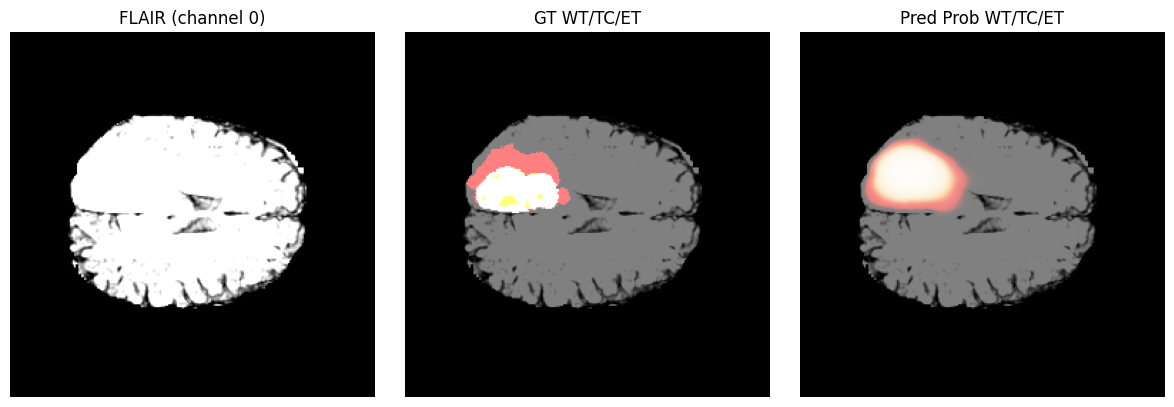

In [11]:
# Python cell
def plot_sample(img_tensor, mask_tensor, pred_logits=None):
    img = img_tensor.cpu().numpy()
    base = img[0]  # FLAIR
    gt = mask_tensor.cpu().numpy()  # (3,H,W)
    fig, axs = plt.subplots(1, 3 if pred_logits is not None else 2, figsize=(12,4))
    axs[0].imshow(base, cmap='gray'); axs[0].set_title('FLAIR (channel 0)'); axs[0].axis('off')
    axs[1].imshow(base, cmap='gray'); overlay = np.zeros((*base.shape,3))
    overlay[...,0] = gt[0]; overlay[...,1] = gt[1]; overlay[...,2] = gt[2]
    axs[1].imshow(overlay, alpha=0.5); axs[1].set_title('GT WT/TC/ET'); axs[1].axis('off')
    if pred_logits is not None:
        pred = torch.sigmoid(pred_logits).cpu().numpy()
        axs[2].imshow(base, cmap='gray'); overlay_p = np.zeros((*base.shape,3))
        overlay_p[...,0] = pred[0]; overlay_p[...,1] = pred[1]; overlay_p[...,2] = pred[2]
        axs[2].imshow(overlay_p, alpha=0.5); axs[2].set_title('Pred Prob WT/TC/ET'); axs[2].axis('off')
    plt.tight_layout(); plt.show()

# get a batch and plot first sample
model.eval()
with torch.no_grad():
    for imgs, masks in val_loader:
        imgs = imgs.to(device); masks = masks.to(device)
        preds = model(imgs)
        plot_sample(imgs[0].cpu(), masks[0].cpu(), preds[0].cpu())
        break
